# Maps for Milvus milvus

<div style="width: 100%;text-align:right;display: flex; align-items: top;">
    <div style="float: left;width: 80%;text-align:left">
        <p><em><a href="mailto:a.dunkel@ioer.de">Alexander Dunkel</a>, Leibniz Institute of Ecological Urban and Regional Development, 
        Transformative Capacities & Research Data Centre (IÖR-FDZ)</em></p>
        <p>Publication:
        <br><em>Dunkel, A., Burghardt, D. (2024). Assessing perceived landscape change from opportunistic spatio-temporal occurrence data. Land 2024</em></p>
    </div>
    <div style="width:256px;text-align:right;margin-top:0px;margin-right:10px"><a href="https://gitlab.hrz.tu-chemnitz.de/ad/temporal_landscapes" style="float:right"><img src="https://code.ad.ioer.info/wip/temporal_landscapes/version.svg" style="float:left"></a></div>
</div>

In [1]:
from IPython.display import Markdown as md
from datetime import date

today = date.today()
with open('/.version', 'r') as file: app_version = file.read().split("'")[1]
md(f"Last updated: {today.strftime('%b-%d-%Y')}, [Carto-Lab Docker](https://gitlab.vgiscience.de/lbsn/tools/jupyterlab) Version {app_version}")

Last updated: Aug-19-2023, [Carto-Lab Docker](https://gitlab.vgiscience.de/lbsn/tools/jupyterlab) Version 0.14.0

Visualization of spatial patterns for Milvus milvus observations (Flickr, iNaturalist).

# Preparations

In [135]:
import os, sys
from pathlib import Path
import psycopg2
import geopandas as gp
import pandas as pd
import seaborn as sns
import numpy as np
import hdbscan
import calendar
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.patheffects as pe
import matplotlib.patches as mpatches
from typing import List, Tuple, Dict, Optional, Any
from IPython.display import clear_output, display, HTML
from datetime import datetime
from pyproj import Transformer
from shapely.geometry import box

In [136]:
module_path = str(Path.cwd().parents[0] / "py")
if module_path not in sys.path:
    sys.path.append(module_path)
from modules.base import tools, hll
from modules.base.hll import union_hll, cardinality_hll

In [137]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [138]:
OUTPUT = Path.cwd().parents[0] / "out"       # output directory for figures (etc.)
WORK_DIR = Path.cwd().parents[0] / "tmp"     # Working directory

In [139]:
(OUTPUT / "figures").mkdir(exist_ok=True)
(OUTPUT / "svg").mkdir(exist_ok=True)
WORK_DIR.mkdir(exist_ok=True)

Plot styling

In [140]:
plt.style.use('default')

In [141]:
CRS_WGS = "epsg:4326" # WGS1984
CRS_PROJ = "esri:54009" # Mollweide
# CRS_PROJ = "esri:102014" # Lambert Conformal Conic

Define Transformer ahead of time with xy-order of coordinates

In [142]:
PROJ_TRANSFORMER = Transformer.from_crs(
    CRS_WGS, CRS_PROJ, always_xy=True)

Set global font

In [143]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

## Load Milvus range

This is the habitat range calculated by iNaturalist observations. The area is currently very broad and includes many locations, where Milvus milvus will be only very seldom observable.

In [144]:
DATA_FOLDER = Path.cwd().parents[0] / "00_data" / "milvus"
range_kml = DATA_FOLDER / "range.kml"

In [145]:
from fiona.drvsupport import supported_drivers
supported_drivers['KML'] = 'rw'

df = gp.read_file(range_kml, driver='KML', ignore_geometry=False)
print(df.crs)

epsg:4326


save to Geopackage, for archive purposes

In [146]:
df.to_file(
    OUTPUT/ 'Milvusmilvus_range.gpkg', driver='GPKG', layer='Milvus milvus')  

project to Mollweide

In [147]:
gdf_range = df.to_crs(CRS_PROJ)

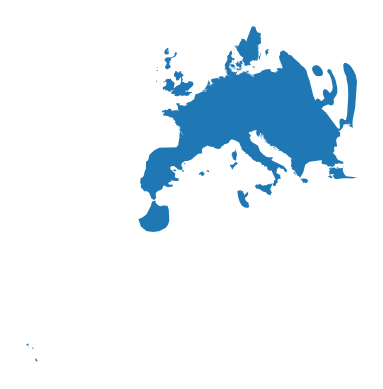

In [148]:
ax = gdf_range.plot()
ax.set_axis_off()

## Load Milvus milvus observations

Load observation data. This data was requested with the iNaturalist `Export tool`, based on a species search for Milvus. Milvus includes 2 species.

In [149]:
df = pd.read_csv(DATA_FOLDER / "observations-350501.csv")

In [150]:
df.head()

,id,observed_on_string,observed_on,time_observed_at,time_zone,user_id,user_login,user_name,created_at,updated_at,...,geoprivacy,taxon_geoprivacy,coordinates_obscured,positioning_method,positioning_device,species_guess,scientific_name,common_name,iconic_taxon_name,taxon_id
0,7793,"May 22, 2010 13:59",2010-05-22,2010-05-22 12:59:00 UTC,London,446,kevinandseri,NaN,2010-07-10 09:15:17 UTC,2016-06-22 18:30:14 UTC,...,NaN,open,False,NaN,NaN,Red Kite,Milvus milvus,Rotmilan,Aves,5267
1,9495,2011-01-01 11:29,2011-01-01,2011-01-01 11:29:00 UTC,London,351,zabdiel,John Proctor,2011-01-01 11:31:50 UTC,2016-06-22 18:32:46 UTC,...,NaN,open,False,NaN,NaN,Red Kite,Milvus milvus,Rotmilan,Aves,5267
2,9496,2011-01-01 11:42,2011-01-01,2011-01-01 11:42:00 UTC,London,351,zabdiel,John Proctor,2011-01-01 11:43:09 UTC,2016-06-22 18:32:46 UTC,...,NaN,open,False,NaN,NaN,red kite,Milvus milvus,Rotmilan,Aves,5267
3,14694,2011-04-17,2011-04-17,NaN,London,654,spookypeanut,NaN,2011-04-17 18:18:12 UTC,2016-06-22 18:44:11 UTC,...,NaN,open,False,NaN,NaN,Red Kite,Milvus milvus,Rotmilan,Aves,5267
4,50134,2011-10-05,2011-10-05,NaN,Berlin,4130,michael,Michael,2012-02-01 19:59:12 UTC,2016-06-22 19:39:03 UTC,...,NaN,open,False,NaN,NaN,Milvus milvus,Milvus milvus,Rotmilan,Aves,5267


In [151]:
df.columns

Index(['id', 'observed_on_string', 'observed_on', 'time_observed_at',
       'time_zone', 'user_id', 'user_login', 'user_name', 'created_at',
       'updated_at', 'quality_grade', 'license', 'url', 'image_url',
       'sound_url', 'tag_list', 'description', 'num_identification_agreements',
       'num_identification_disagreements', 'captive_cultivated',
       'oauth_application_id', 'place_guess', 'latitude', 'longitude',
       'positional_accuracy', 'private_place_guess', 'private_latitude',
       'private_longitude', 'public_positional_accuracy', 'geoprivacy',
       'taxon_geoprivacy', 'coordinates_obscured', 'positioning_method',
       'positioning_device', 'species_guess', 'scientific_name', 'common_name',
       'iconic_taxon_name', 'taxon_id'],
      dtype='object')

In [152]:
milvus_inat = gp.GeoDataFrame(
    df, geometry=gp.points_from_xy(df.longitude, df.latitude), crs=CRS_WGS)
milvus_inat.to_crs(CRS_PROJ, inplace=True)

Load world countries geometry

In [153]:
world = tools.get_shapes("world", shape_dir=OUTPUT / "shapes")

Already exists


In [154]:
world.to_crs(CRS_PROJ, inplace=True)

In [155]:
bbox_europe = -25, 35, 35, 59
# convert to Mollweide
minx, miny = PROJ_TRANSFORMER.transform(
    bbox_europe[0], bbox_europe[1])
maxx, maxy = PROJ_TRANSFORMER.transform(
    bbox_europe[2], bbox_europe[3])

In [156]:
RANGE_COLOR = "#810f7c"
OBSERVATION_COLOR = "red"

Create legend manually

In [157]:
range_patch = mpatches.Patch(
    color=RANGE_COLOR,
    label='Range, Milvus milvus', alpha=0.4)
obs_patch = mpatches.Patch(
    color=OBSERVATION_COLOR,
    label='Observations', alpha=0.9)
legend_entries = [range_patch, obs_patch]
legend_kwds = {
    "bbox_to_anchor": (1.0, 1),
    "loc":'upper left',
    "fontsize":8, "frameon":False,
    "title":"Milvus milvus", "title_fontsize":8,
    "alignment":"left"}

In [158]:
def plot_map(
    gdf: gp.GeoDataFrame, x_lim: [Tuple[float, float]] = None, y_lim: [Tuple[float, float]] = None,
    gdf_range: gp.GeoDataFrame = None, world: gp.GeoDataFrame = None,
    legend_entries: List[mpatches.Patch] = None, legend_kwds: Dict[str, Any]  = None, 
    range_color: str = RANGE_COLOR, observation_color: str = OBSERVATION_COLOR, fig_size: Tuple[int, int] = None,
    return_ax: bool = None):
    """Plot a point map with legend and optional range-shape"""
    if fig_size is None:
        fig_size = (6, 9)
    fig, ax = plt.subplots(1, 1, figsize=fig_size)
    if gdf_range is not None:
        gdf_range.plot(
            ax=ax,
            facecolor=range_color,
            edgecolor=None,
            alpha=0.4)
    gdf.plot(
        ax=ax,
        markersize=.1,
        facecolor=observation_color,
        edgecolor=None,
        alpha=0.9)
    if world is not None:
        world.plot(
            ax=ax, color='none', edgecolor='black', linewidth=0.3)
    if not None in [x_lim, y_lim]:
        ax.set_xlim(*x_lim)
        ax.set_ylim(*y_lim)
    ax.axis('off')
    if not None in [legend_entries, legend_kwds]:
        ax.legend(
            handles=legend_entries, **legend_kwds)
    fig.tight_layout()
    if return_ax:
        return fig, ax
    fig.show()

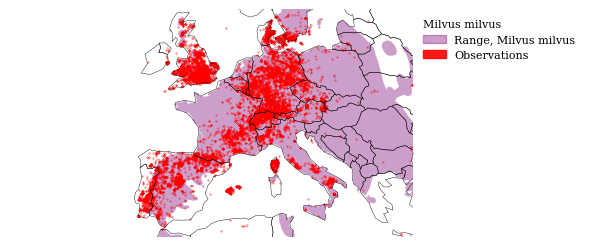

In [159]:
fig, ax = plot_map(
    milvus_inat, x_lim=(minx, maxx), y_lim=(miny, maxy), 
    gdf_range=gdf_range, world=world, legend_entries=legend_entries, 
    legend_kwds=legend_kwds, return_ax=True)
fig.show()
tools.save_fig(fig, output=OUTPUT, name="milvus_inat_europe")

Zoom in

In [160]:
bbox_germany = world[world.index == "Germany"].bounds.values.squeeze()
minx, miny = bbox_germany[0], bbox_germany[1]
maxx, maxy = bbox_germany[2], bbox_germany[3]

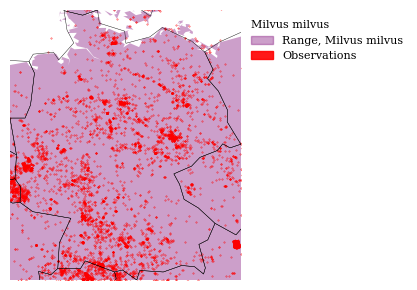

In [161]:
plot_map(
    milvus_inat, x_lim=(minx, maxx), y_lim=(miny, maxy), 
    gdf_range=gdf_range, world=world, 
    legend_entries=legend_entries, legend_kwds=legend_kwds, fig_size=(6,3))

## Find clusters (HDBSCAN)

We just want to see distribution and major clusters. A more interactive approach is shown by João Paulo Figueira's [Geographic Clustering with HDBSCAN](https://medium.com/data-science/geographic-clustering-with-hdbscan-ef8cb0ed6051)

In [162]:
data = np.array(list(zip(df.longitude, df.latitude)))

In [163]:
X = np.radians(data) # convert the list of lat/lon coordinates to radians
earth_radius_km = 6371
epsilon = 0.005 / earth_radius_km # calculate 5 meter epsilon threshold

clusterer = hdbscan.HDBSCAN(min_cluster_size=100, metric='haversine').fit(X)

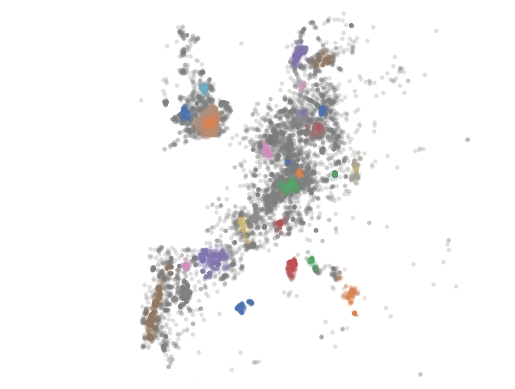

In [164]:
color_palette = sns.color_palette('deep', len(clusterer.labels_))
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
fig, ax = plt.subplots()
ax.scatter(*data.T, s=10, linewidth=0, c=cluster_member_colors, alpha=0.25)
ax.set_xlim(bbox_europe[0], bbox_europe[1])
ax.set_ylim(bbox_europe[2], bbox_europe[3])
ax.axis('off')
fig.show()

## Load Milvus milvus Flickr observations (worldwide)

In [165]:
flickr_observations = DATA_FOLDER / "2022-02-17_milvusmilvus.csv"

In [166]:
df = pd.read_csv(flickr_observations)

Time format: see [Python strftime cheatsheet](https://strftime.org/)

In [167]:
load_kwargs = {
    "index_col":'datetime', 
    "parse_dates":{'datetime':["post_create_date"]},
    "date_format":'%Y-%m-%d %H:%M:%S',
    "keep_date_col":'False',
    "usecols":["post_guid", "post_create_date", "latitude", "longitude"]
}

df = pd.read_csv(flickr_observations, **load_kwargs)

In [168]:
df.head(1)

,post_guid,latitude,longitude,post_create_date
datetime,,,,
2012-10-01,XSQGXtc9wWIHX6XiEtdaOqgKPURZ7tZtIRere0IA7wQ,52.246984,-3.628835,2012-10-01


In [169]:
milvus_flickr = gp.GeoDataFrame(
    df, geometry=gp.points_from_xy(df.longitude, df.latitude), crs=CRS_WGS)
milvus_flickr.to_crs(CRS_PROJ, inplace=True)

plot

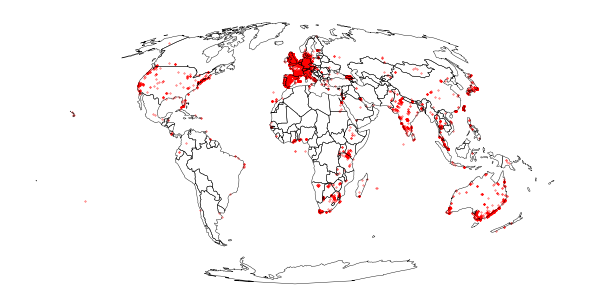

In [170]:
plot_map(
    milvus_flickr, world=world)

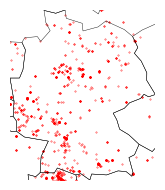

In [171]:
plot_map(
    milvus_flickr, world=world, x_lim=(minx, maxx), y_lim=(miny, maxy), fig_size=(4,2))

## Saxony-Anhalt

According to Nicolai, Mammen & Kolbe (2017), the highest population of the Red Kite is found in Saxony-Anhalt.

<cite><strong>Nicolai, B., Mammen, U., & Kolbe, M. (2017).</strong> Long-term changes in population and habitat selection of Red Kite Milvus milvus in the region with the highest population density. VOGELWELT 137: 194–197 (2017)
</cite>

Below, we visualize this area, merging Flickr and iNaturalist observations.

In [172]:
shapes = tools.get_shapes("de", shape_dir=OUTPUT / "shapes", project_wgs84=False)

Loaded 5.10 MB of 5.11 (100%)..
Extracting zip..
Retrieved vg2500_12-31.utm32s.shape.zip, extracted size: 0.73 MB


We want to filter by Saxony-Anhalt with a buffer of 100 km

In [173]:
geom_saxonya = shapes[shapes.index == "Sachsen-Anhalt"]

Get bounds of Saxony-Anhalt

In [174]:
geom_saxonya_bbox = box(*geom_saxonya.total_bounds)

Project and concat Flickr and iNaturalist observations

In [175]:
milvus_gdf = pd.concat(
    [milvus_flickr.to_crs(shapes.crs), milvus_inat.to_crs(shapes.crs)])

Clip observations to bounds of Saxony-Anhalt (only iNat, as there are only 4 Flickr obervations of Milvus in the focus region)

Note: We could also use `gp.overlay()` here, e.g.:
```python
gdf_select = gp.overlay(
    milvus_gdf, geom_saxonya_bbox,
    how='intersection')
```

In [176]:
gdf_select = gp.clip(milvus_inat.to_crs(shapes.crs), mask=geom_saxonya_bbox)

In [177]:
len(gdf_select)

856

Set bounds of Saxony-Anhalt as plotting limits

In [178]:
bbox_saxonya = geom_saxonya.bounds.values.squeeze()

In [179]:
bbox_saxonya

array([ 607181.85913772, 5647848.4600198 ,  789161.6620191 ,
       5880180.07203066])

In [180]:
minx, miny = bbox_saxonya[0], bbox_saxonya[1]
maxx, maxy = bbox_saxonya[2], bbox_saxonya[3]

In [181]:
bbox_layer = gp.GeoDataFrame(index=[0], crs=shapes.crs.to_epsg(), geometry=[geom_saxonya_bbox])

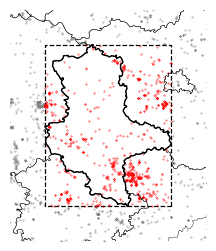

In [182]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax = milvus_gdf.plot(
    ax=ax,
    markersize=.1,
    facecolor="grey",
    edgecolor=None,
    alpha=0.9)
ax = bbox_layer.plot(
    ax=ax, color='white', edgecolor='black', 
    linewidth=0.9, linestyle='dashed')
ax = gdf_select.plot(
    ax=ax,
    markersize=.1,
    facecolor=OBSERVATION_COLOR,
    edgecolor=None,
    alpha=0.9)
ax = shapes.plot(
    ax=ax, color='none', edgecolor='black', linewidth=0.3)
ax = shapes[shapes.index == "Sachsen-Anhalt"].plot(
    ax=ax, color='none', edgecolor='black', linewidth=1)
buf = 50000 # 50km
ax.axis('off')
ax.set_xlim((minx-buf, maxx+buf))
ax.set_ylim((miny-buf, maxy+buf))
fig.show()

In [183]:
tools.save_fig(fig, output=OUTPUT, name="focus_region")

WGS bounds:

In [184]:
bbox_layer.to_crs(CRS_WGS).bounds.values.squeeze()

array([10.52659544, 50.90971941, 13.30916778, 53.0603523 ])

Update our Europe plot with the bounds of the close-up region.

In [185]:
bbox_europe = -25, 35, 35, 59
# convert to Mollweide
minx, miny = PROJ_TRANSFORMER.transform(
    bbox_europe[0], bbox_europe[1])
maxx, maxy = PROJ_TRANSFORMER.transform(
    bbox_europe[2], bbox_europe[3])

Update legend

In [186]:
outside_patch = mpatches.Patch(
    # color="tab:blue", # default matplotlib blue
    color="grey",
    label='Outside analysis bounds', alpha=0.9)
if len(legend_entries) > 2:
    legend_entries.pop()
legend_entries.append(outside_patch)

In [187]:
bbox_layer.loc[0, "name"] = "Focus Region"

In [188]:
label_off = {
    "Focus Region":(-2000000, 500000),
}
label_rad = {
    "Focus Region":-0.2,
}

Annotatipn arrow ending at lower-right corner

In [189]:
lower_right = (
    bbox_layer.to_crs(CRS_PROJ).bounds.values.squeeze()[2],
    bbox_layer.to_crs(CRS_PROJ).bounds.values.squeeze()[1])

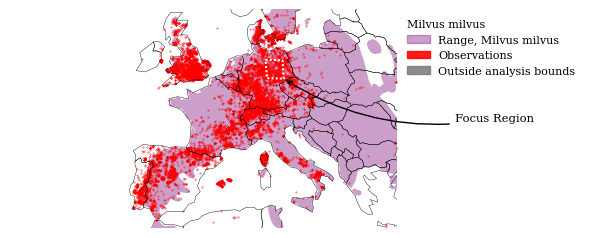

In [190]:
fig, ax = plot_map(
    milvus_inat, x_lim=(minx, maxx), y_lim=(miny, maxy), 
    gdf_range=gdf_range, world=world, 
    legend_entries=legend_entries, legend_kwds=legend_kwds, return_ax=True)
ax = bbox_layer.to_crs(CRS_PROJ).plot(
    ax=ax, color='none', edgecolor='white', 
    linewidth=1.5, linestyle=(0, (1,1)))
tools.annotate_locations(
    gdf=bbox_layer, ax=ax, label_off=label_off, label_rad=label_rad, 
    text_col="name", arrowstyle='->', arrow_col='black', fontsize="small",
    coords=lower_right)
fig.show()

In [191]:
tools.save_fig(fig, output=OUTPUT, name="milvus_inat_europe_annotated")

# Create notebook HTML

In [2]:
!jupyter nbconvert --to html_toc \
    --output-dir=../resources/html/ ./09_milvus_maps.ipynb \
    --template=../nbconvert.tpl \
    --ExtractOutputPreprocessor.enabled=False >&- 2>&-